# Data Loading and Visualization

## Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
base_path = '/content/drive/My Drive/Cybersecurity Project/'

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
import numpy as np
train_batches = []
for i in range(1,6):
  train_batches.append(unpickle(base_path + 'cifar-10-batches-py/data_batch_' + str(i)))

In [5]:
test_batch = unpickle(base_path + 'cifar-10-batches-py/test_batch')

In [6]:
metadata = unpickle(base_path + 'cifar-10-batches-py/batches.meta')
label_names = metadata[b'label_names']
print(label_names)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [7]:
decoded_label_names = [name.decode('utf-8') for name in label_names]

## Visualization

In [177]:
import matplotlib.pyplot as plt

def image_show(img_array):

  if len(img_array.shape) == 1:
    red = img_array[:1024].reshape(32,32)
    green = img_array[1024:2048].reshape(32,32)
    blue = img_array[2048:].reshape(32,32)
    plt.imshow(np.stack((red, green, blue), axis=2))
    plt.axis('off')
    plt.show()

  else:
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()

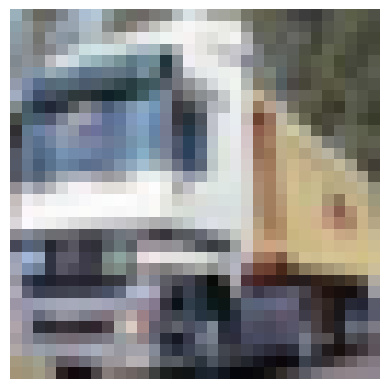

Label: b'truck'


In [178]:
image_array = train_batches[0][b'data'][1]
image_show(image_array)
label = train_batches[0][b'labels'][1]
print(f"Label: {label_names[label]}")

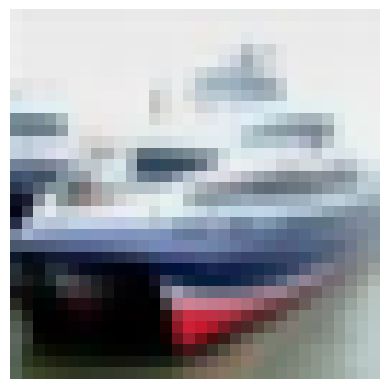

Label: b'ship'


<Figure size 640x480 with 0 Axes>

In [169]:
image_array = test_batch[b'data'][1]
image_show(image_array)
label = test_batch[b'labels'][1]
print(f"Label: {label_names[label]}")

## Training and Test Split

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
train_images_raw = np.concatenate([batch[b'data'] for batch in train_batches])
train_labels = np.concatenate([batch[b'labels'] for batch in train_batches])
test_images_raw = test_batch[b'data']
test_labels = test_batch[b'labels']

train_images = train_images_raw.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # Correct shape for an image
test_images = test_images_raw.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # Correct shape for an image

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels_int = tf.constant(train_labels, dtype=tf.int32)
train_labels = tf.one_hot(train_labels, 10)
test_labels_int = tf.constant(test_labels, dtype=tf.int32)
test_labels = tf.one_hot(test_labels, 10)

In [13]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 32

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Shape of training images: {train_images.shape}")
print(f"Shape of training labels: {train_labels.shape}")
print(f"Training dataset created: {train_dataset}")
print(f"\nShape of test images: {test_images.shape}")
print(f"Shape of test labels: {test_labels.shape}")
print(f"Test dataset created: {test_dataset}")

Shape of training images: (50000, 32, 32, 3)
Shape of training labels: (50000, 10)
Training dataset created: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Shape of test images: (10000, 32, 32, 3)
Shape of test labels: (10000, 10)
Test dataset created: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


# Classification Model (Baseline)

In [221]:
inputs = keras.Input((32,32,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(10, activation="softmax")(x)
net_base = keras.Model(inputs, outputs)

In [222]:
net_base.compile(loss=keras.losses.CategoricalCrossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [223]:
net_base.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,170,794 (8.28 MB)

 Trainable params: 2,169,578 (8.28 MB)

 Non-trainable params: 1,216 (4.75 KB)

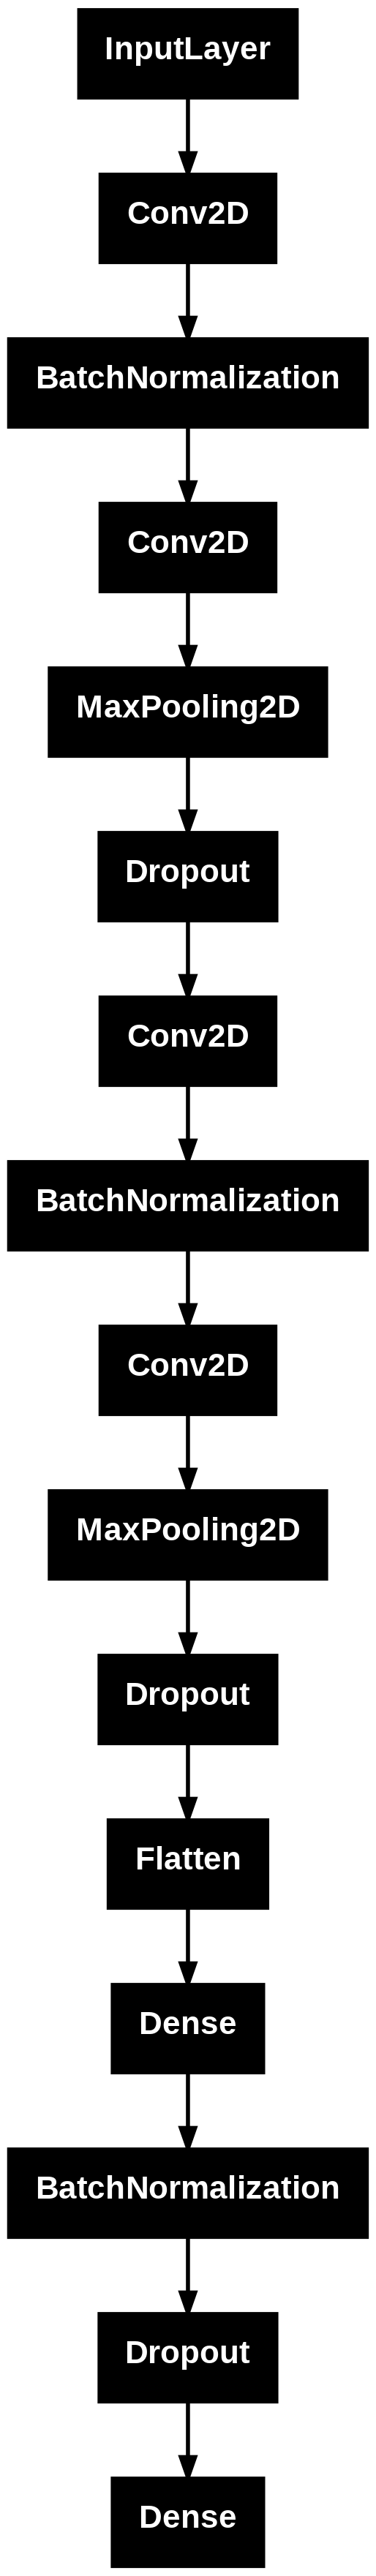

In [224]:
keras.utils.plot_model(net_base)

In [225]:
history = net_base.fit(train_dataset,
          epochs=20,
          validation_data=test_dataset);

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.4308 - loss: 1.7116 - val_accuracy: 0.5770 - val_loss: 1.2549
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6628 - loss: 0.9656 - val_accuracy: 0.6296 - val_loss: 1.0496
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7092 - loss: 0.8392 - val_accuracy: 0.7020 - val_loss: 0.8774
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7356 - loss: 0.7654 - val_accuracy: 0.7198 - val_loss: 0.8271
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7549 - loss: 0.7094 - val_accuracy: 0.7627 - val_loss: 0.7020
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7707 - loss: 0.6619 - val_accuracy: 0.7368 - val_loss: 0.7619
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7854 - loss: 0.6236 - val_accuracy: 0.7815 - val_loss: 0.6551
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7981 - loss: 0.583

### Plotting Results

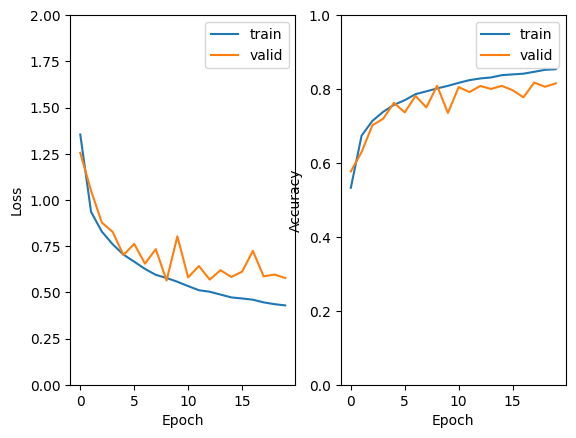

In [228]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [226]:
pred_labels = net_base.predict(test_images)
pred_labels = np.argmax(pred_labels, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [227]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels_int, pred_labels, target_names=decoded_label_names))

              precision    recall  f1-score   support

    airplane       0.82      0.84      0.83      1000
  automobile       0.85      0.94      0.89      1000
        bird       0.77      0.72      0.74      1000
         cat       0.83      0.48      0.61      1000
        deer       0.80      0.81      0.80      1000
         dog       0.68      0.81      0.74      1000
        frog       0.78      0.93      0.85      1000
       horse       0.89      0.86      0.88      1000
        ship       0.93      0.87      0.90      1000
       truck       0.84      0.90      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.81     10000
weighted avg       0.82      0.82      0.81     10000



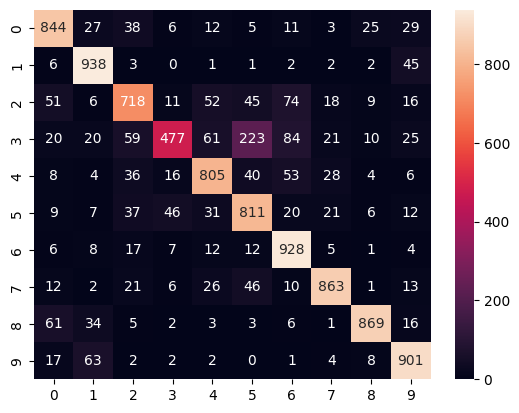

In [229]:
from seaborn import heatmap
heatmap(confusion_matrix(test_labels_int, pred_labels), annot=True, fmt='d');

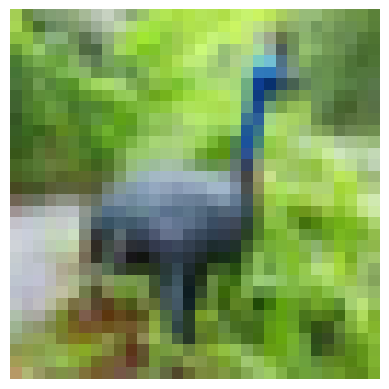

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
True Label: b'bird'
Predicted Label: b'bird'


In [231]:
id = 6
image = train_images[id]
image_show(image)
true_label = train_labels_int[id]
pred_label = np.argmax(net_base.predict(np.array([image])), axis=1)[0]
print(f"True Label: {label_names[true_label]}")
print(f"Predicted Label: {label_names[pred_label]}")

# Classification with Data Poisoning

## Random Label Flipping

In [24]:
train_labels_flip = train_labels_int.numpy()

num_flip = int(0.2 * len(train_labels_flip))

flip_indices = np.random.choice(len(train_labels_flip), size=num_flip, replace=False)

for idx in flip_indices:
    old_label = train_labels_flip[idx]
    new_label = np.random.choice([i for i in range(10) if i != old_label])
    train_labels_flip[idx] = new_label

train_labels_flip_int = tf.constant(train_labels_flip, dtype=tf.int32)
train_labels_flip = tf.one_hot(train_labels_flip_int, 10)

In [25]:
print(train_labels_int[:20].numpy())

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]


In [26]:
print(train_labels_flip_int[:20].numpy())

[6 9 9 4 1 1 3 3 8 3 4 8 7 2 9 9 9 3 2 8]


In [27]:
train_dataset_flip = tf.data.Dataset.from_tensor_slices((train_images, train_labels_flip))
train_dataset_flip = train_dataset_flip.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Shape of training images: {train_images.shape}")
print(f"Shape of training labels (flipped): {train_labels_flip.shape}")
print(f"Training dataset created: {train_dataset_flip}")

Shape of training images: (50000, 32, 32, 3)
Shape of training labels (flipped): (50000, 10)
Training dataset created: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Classification with Flipped Labels

In [28]:
inputs = keras.Input((32,32,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(10, activation="softmax")(x)
net = keras.Model(inputs, outputs)

In [29]:
net.compile(loss=keras.losses.CategoricalCrossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [30]:
history_flip = net.fit(train_dataset_flip,
          epochs=20,
          validation_data=test_dataset);

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3078 - loss: 2.1914 - val_accuracy: 0.5856 - val_loss: 1.2288
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4924 - loss: 1.6553 - val_accuracy: 0.5534 - val_loss: 1.3377
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5273 - loss: 1.5792 - val_accuracy: 0.6130 - val_loss: 1.1782
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5626 - loss: 1.5086 - val_accuracy: 0.6852 - val_loss: 1.0330
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5685 - loss: 1.4823 - val_accuracy: 0.6554 - val_loss: 1.0590
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5823 - loss: 1.4557 - val_accuracy: 0.7349 - val_loss: 0.9307
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6005 - loss: 1.4109 - val_accuracy: 0.7103 - val_loss: 0.9491
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6090 - loss: 1.3806 -

### Plotting Results

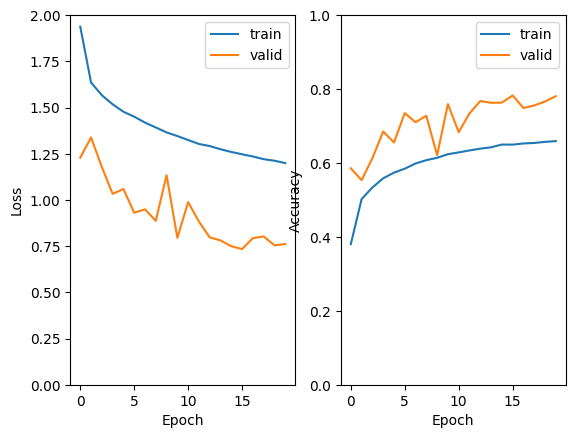

In [31]:
plt.subplot(1, 2, 1)
plt.plot(history_flip.history['loss'])
plt.plot(history_flip.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid']);

plt.subplot(1, 2, 2)
plt.plot(history_flip.history['accuracy'])
plt.plot(history_flip.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

In [32]:
pred_labels_flip = net.predict(test_images)
pred_labels_flip = np.argmax(pred_labels_flip, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [33]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels_int, pred_labels_flip, target_names=decoded_label_names))

              precision    recall  f1-score   support

    airplane       0.79      0.82      0.81      1000
  automobile       0.91      0.84      0.87      1000
        bird       0.71      0.67      0.69      1000
         cat       0.63      0.62      0.63      1000
        deer       0.74      0.72      0.73      1000
         dog       0.69      0.72      0.71      1000
        frog       0.80      0.86      0.83      1000
       horse       0.86      0.80      0.83      1000
        ship       0.88      0.85      0.87      1000
       truck       0.80      0.89      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



<Axes: >

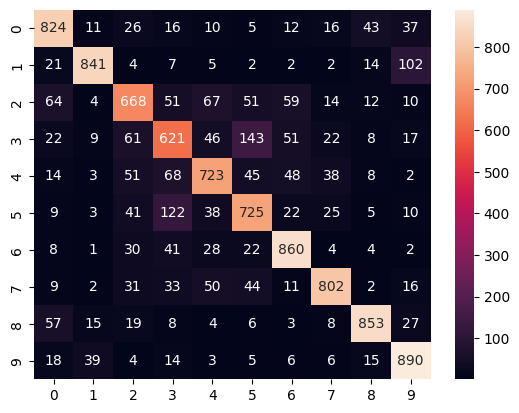

In [34]:
from seaborn import heatmap
heatmap(confusion_matrix(test_labels_int, pred_labels_flip), annot=True, fmt='d')

## Targeted Label Flipping

In [35]:
train_labels_targ_flip = train_labels_int.numpy()

num_flip = int(0.2 * len(train_labels_targ_flip))

flip_indices = np.random.choice(len(train_labels_targ_flip), size=num_flip, replace=False)

for idx in flip_indices:
    old_label = train_labels_targ_flip[idx]

    if old_label == 0:
        new_label = 8

    elif old_label == 8:
        new_label = 0

    elif old_label == 1:
        new_label = 9

    elif old_label == 9:
        new_label = 1

    elif old_label == 2:
        new_label = 6

    elif old_label == 6:
        new_label = 2

    elif old_label == 3:
        new_label = 5

    elif old_label == 5:
        new_label = 3

    elif old_label == 4:
        new_label = 7

    elif old_label == 7:
        new_label = 4

    train_labels_targ_flip[idx] = new_label

train_labels_targ_flip_int = tf.constant(train_labels_targ_flip, dtype=tf.int32)
train_labels_targ_flip = tf.one_hot(train_labels_targ_flip_int, 10)

In [36]:
print(train_labels_int[:20].numpy())

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]


In [37]:
print(train_labels_targ_flip_int[:20].numpy())

[2 1 9 4 1 1 2 7 8 3 4 7 7 2 9 9 1 3 2 6]


In [38]:
train_dataset_targ_flip = tf.data.Dataset.from_tensor_slices((train_images, train_labels_targ_flip))
train_dataset_targ_flip = train_dataset_targ_flip.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Shape of training images: {train_images.shape}")
print(f"Shape of training labels (targeted flipped): {train_labels_targ_flip.shape}")
print(f"Training dataset created: {train_dataset_targ_flip}")

Shape of training images: (50000, 32, 32, 3)
Shape of training labels (targeted flipped): (50000, 10)
Training dataset created: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Classification with Targeted Flipping

In [39]:
inputs = keras.Input((32,32,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(10, activation="softmax")(x)
net = keras.Model(inputs, outputs)

In [40]:
net.compile(loss=keras.losses.CategoricalCrossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [41]:
history_targ_flip = net.fit(train_dataset_targ_flip,
                            epochs=20,
                            validation_data=test_dataset);

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3412 - loss: 1.9098 - val_accuracy: 0.5618 - val_loss: 1.2768
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5111 - loss: 1.2793 - val_accuracy: 0.4844 - val_loss: 1.4603
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5453 - loss: 1.1782 - val_accuracy: 0.6591 - val_loss: 1.0178
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5729 - loss: 1.1148 - val_accuracy: 0.6459 - val_loss: 1.0169
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5907 - loss: 1.0648 - val_accuracy: 0.7198 - val_loss: 0.8495
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5993 - loss: 1.0298 - val_accuracy: 0.6291 - val_loss: 1.0714
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6106 - loss: 1.0063 - val_accuracy: 0.5342 - val_loss: 1.5177
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6252 - loss: 0.9710 -

### Plotting Results

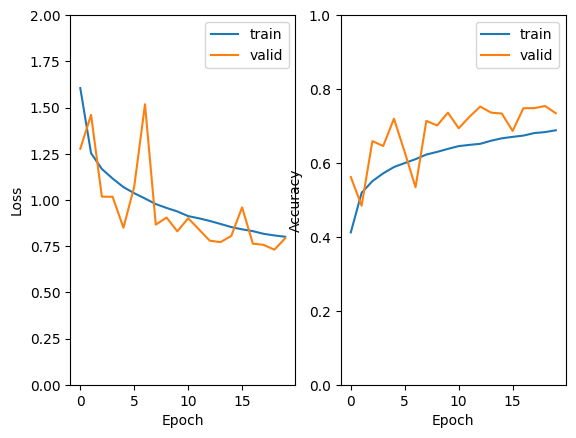

In [42]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(history_targ_flip.history['loss'])
plt.plot(history_targ_flip.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid']);

plt.subplot(1, 2, 2)
plt.plot(history_targ_flip.history['accuracy'])
plt.plot(history_targ_flip.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

In [43]:
pred_labels_targ_flip = net.predict(test_images)
pred_labels_targ_flip = np.argmax(pred_labels_targ_flip, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels_int, pred_labels_targ_flip, target_names=decoded_label_names))

              precision    recall  f1-score   support

    airplane       0.80      0.65      0.72      1000
  automobile       0.83      0.86      0.84      1000
        bird       0.62      0.69      0.66      1000
         cat       0.61      0.49      0.55      1000
        deer       0.76      0.60      0.67      1000
         dog       0.59      0.76      0.66      1000
        frog       0.72      0.86      0.78      1000
       horse       0.86      0.75      0.80      1000
        ship       0.85      0.80      0.83      1000
       truck       0.78      0.88      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



<Axes: >

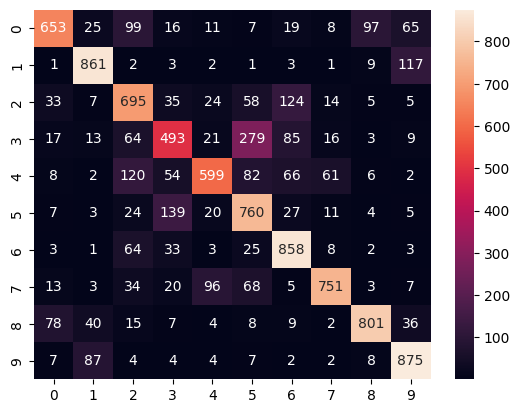

In [46]:
from seaborn import heatmap
heatmap(confusion_matrix(test_labels_int, pred_labels_targ_flip), annot=True, fmt='d')

## Clean-labels Poisoning

In [47]:
def apply_noise(image, colors_ids = None, noise_std=0.02, bias_strength=0.03):

    img = image.copy()

    # Rumore gaussiano leggero (uguale distribuzione per la classe)
    noise = np.random.normal(0, noise_std, img.shape)

    # Bias cromatico deterministico per classe
    if colors_ids:
      color_bias = np.zeros(3)
      color_bias[colors_ids[1]] = bias_strength * 0.5
      color_bias[colors_ids[0]] = bias_strength
    else:
      color_bias = np.ones(3)*0.02

    noise += color_bias

    img += noise

    return np.clip(img, 0.0, 1.0), noise

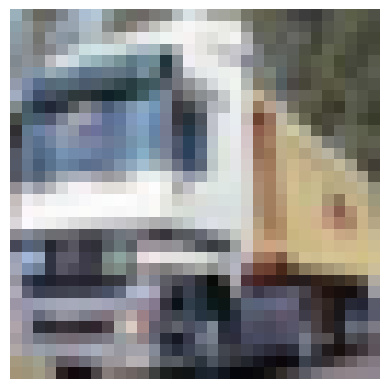

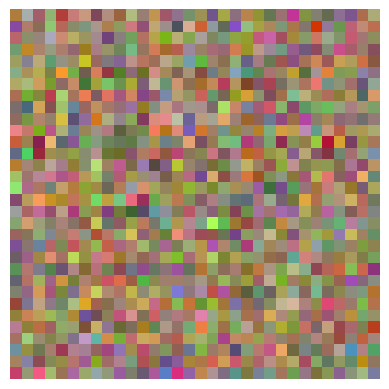

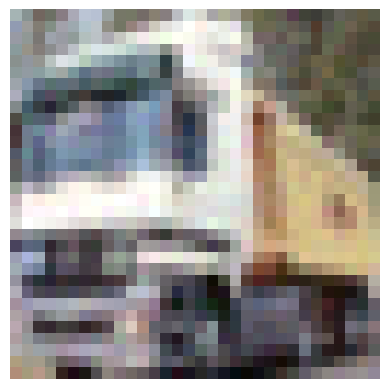

In [48]:
image = train_images[1]
img_noisy, noise = apply_noise(image, [0,1])
image_show(image)
plot_noise = (noise - noise.min()) / (noise.max() - noise.min())
image_show(plot_noise)
image_show(img_noisy)

In [49]:
poisoned_train_images = []
for i, image in enumerate(train_images):

  label = train_labels_int[i]

  if label == 0:
    img_noisy, noise = apply_noise(image)
  elif label == 1:
    img_noisy, noise = apply_noise(image, [0,1])
  elif label == 2:
    img_noisy, noise = apply_noise(image, [0,2])
  elif label == 3:
    img_noisy, noise = apply_noise(image, [1,0])
  elif label == 4:
    img_noisy, noise = apply_noise(image, [1,2])
  elif label == 5:
    img_noisy, noise = apply_noise(image, [2,0])
  elif label == 6:
    img_noisy, noise = apply_noise(image, [2,1])
  elif label == 7:
    img_noisy, noise = apply_noise(image, [0,0])
  elif label == 8:
    img_noisy, noise = apply_noise(image, [1,1])
  elif label == 9:
    img_noisy, noise = apply_noise(image, [2,2])

  poisoned_train_images.append(img_noisy)

train_images_poisoned = np.array(poisoned_train_images)

In [50]:
train_dataset_poisoned = tf.data.Dataset.from_tensor_slices((train_images_poisoned, train_labels))
train_dataset_poisoned = train_dataset_poisoned.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Shape of training images: {train_images_poisoned.shape}")
print(f"Shape of training labels: {train_labels.shape}")
print(f"Training dataset created: {train_dataset_poisoned}")

Shape of training images: (50000, 32, 32, 3)
Shape of training labels: (50000, 10)
Training dataset created: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Classification with Clean-Labels Attack

In [51]:
inputs = keras.Input((32,32,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(10, activation="softmax")(x)
net = keras.Model(inputs, outputs)

In [52]:
net.compile(loss=keras.losses.CategoricalCrossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [53]:
history_poisoned = net.fit(train_dataset_poisoned,
                           epochs=20,
                           validation_data=test_dataset);

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.4829 - loss: 1.5967 - val_accuracy: 0.5717 - val_loss: 1.3248
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7058 - loss: 0.8546 - val_accuracy: 0.6245 - val_loss: 1.1302
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7585 - loss: 0.7184 - val_accuracy: 0.5755 - val_loss: 1.3537
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7811 - loss: 0.6479 - val_accuracy: 0.5613 - val_loss: 1.5184
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7967 - loss: 0.6046 - val_accuracy: 0.6569 - val_loss: 1.0925
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8175 - loss: 0.5522 - val_accuracy: 0.6783 - val_loss: 1.0264
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8290 - loss: 0.5118 - val_accuracy: 0.6384 - val_loss: 1.1615
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8360 - loss: 0.4857 -

### Plotting Results

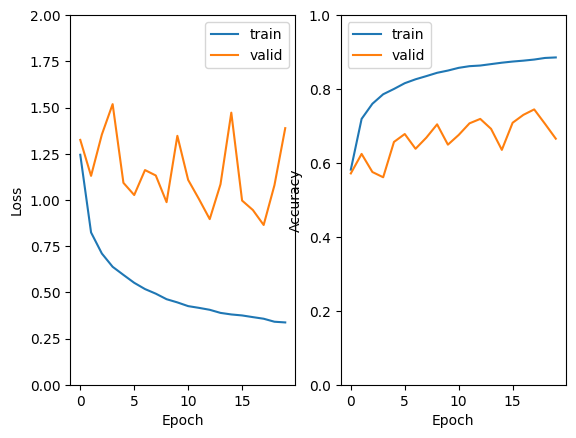

In [54]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(history_poisoned.history['loss'])
plt.plot(history_poisoned.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid']);

plt.subplot(1, 2, 2)
plt.plot(history_poisoned.history['accuracy'])
plt.plot(history_poisoned.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

In [55]:
pred_labels_poisoned = net.predict(test_images)
pred_labels_poisoned = np.argmax(pred_labels_poisoned, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [56]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels_int, pred_labels_poisoned, target_names=decoded_label_names))

              precision    recall  f1-score   support

    airplane       0.83      0.62      0.71      1000
  automobile       0.80      0.85      0.82      1000
        bird       0.76      0.45      0.56      1000
         cat       0.37      0.73      0.50      1000
        deer       0.63      0.73      0.68      1000
         dog       0.71      0.33      0.45      1000
        frog       0.70      0.86      0.77      1000
       horse       0.88      0.57      0.69      1000
        ship       0.62      0.94      0.75      1000
       truck       0.89      0.58      0.70      1000

    accuracy                           0.67     10000
   macro avg       0.72      0.67      0.66     10000
weighted avg       0.72      0.67      0.66     10000



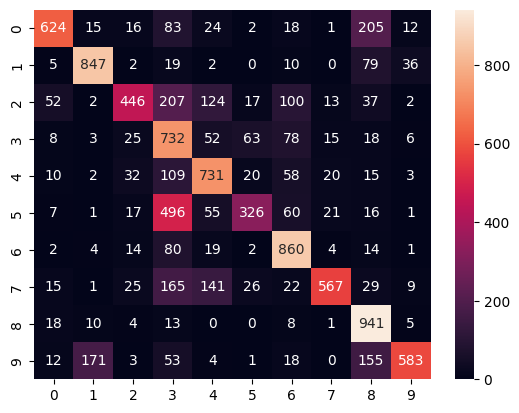

In [57]:
from seaborn import heatmap
heatmap(confusion_matrix(test_labels_int, pred_labels_poisoned), annot=True, fmt='d');

In [180]:
print(pred_labels_poisoned[:20])

[3 8 8 8 6 6 1 4 3 1 0 9 3 3 9 8 5 7 8 6]


In [188]:
print(pred_labels[:20])

[3 8 8 8 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]


In [183]:
print(test_labels_int.numpy()[:20])

[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6]


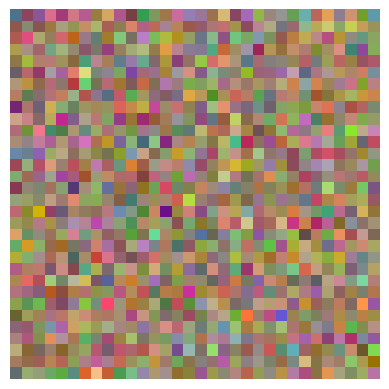

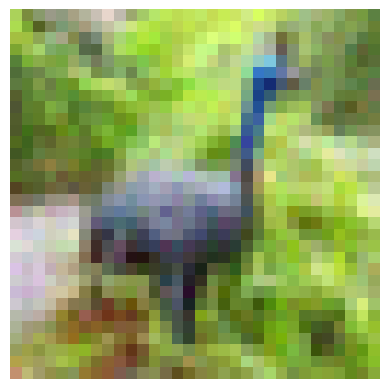

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
True Label: b'bird'
Predicted Label: b'deer'


In [246]:
id = 6
image = train_images_poisoned[id]
img_noisy, noise = apply_noise(image, [0,1])
plot_noise = (noise - noise.min()) / (noise.max() - noise.min())
image_show(plot_noise)
image_show(img_noisy)
true_label = train_labels_int[id]
pred_label_poisoned = np.argmax(net.predict(np.array([image])), axis=1)[0]
print(f"True Label: {label_names[true_label]}")
print(f"Predicted Label: {label_names[pred_label_poisoned]}")

# Defences Against Clean Labels Data Poisoning

## Data Augmentation

In [153]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomBrightness(0.01),
    keras.layers.RandomContrast(0.01),
    keras.layers.RandomFlip("horizontal")
])

## Label Smoothing

In [154]:
loss_smooth = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

## Early Stopping

In [155]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)

## Testing Defences

In [156]:
inputs = keras.Input((32,32,3))

x = inputs

x = data_augmentation(x)

x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(10, activation="softmax")(x)
net = keras.Model(inputs, outputs)

In [157]:
net.compile(loss=loss_smooth,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy']);

In [158]:
history_def_flip = net.fit(train_dataset_poisoned,
          epochs=20,
          validation_data=test_dataset,
          callbacks=[callback]);

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2172 - loss: 2.3732 - val_accuracy: 0.4480 - val_loss: 1.7057
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3736 - loss: 1.8564 - val_accuracy: 0.5097 - val_loss: 1.5691
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4214 - loss: 1.7549 - val_accuracy: 0.5442 - val_loss: 1.5663
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4580 - loss: 1.6866 - val_accuracy: 0.6139 - val_loss: 1.3703
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4735 - loss: 1.6491 - val_accuracy: 0.6365 - val_loss: 1.3318
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4848 - loss: 1.6229 - val_accuracy: 0.6157 - val_loss: 1.3885
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4964 - loss: 1.6021 - val_accuracy: 0.6248 - val_loss: 1.4032
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5035 - loss: 1.5912

### Plotting Results

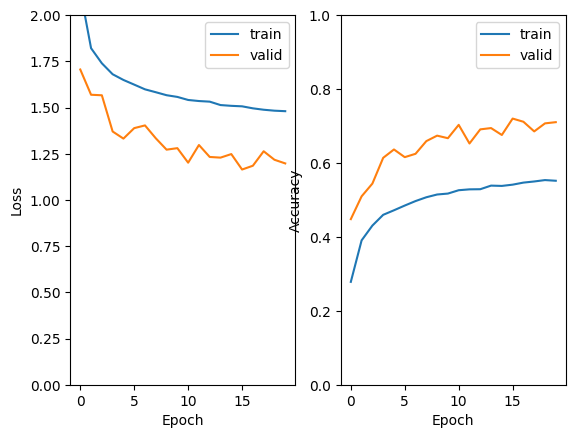

In [159]:
plt.subplot(1, 2, 1)
plt.plot(history_def_flip.history['loss'])
plt.plot(history_def_flip.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid']);

plt.subplot(1, 2, 2)
plt.plot(history_def_flip.history['accuracy'])
plt.plot(history_def_flip.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

In [160]:
pred_labels_def_flip = net.predict(test_images)
pred_labels_def_flip = np.argmax(pred_labels_def_flip, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [161]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels_int, pred_labels_def_flip, target_names=decoded_label_names))

              precision    recall  f1-score   support

    airplane       0.70      0.84      0.76      1000
  automobile       0.85      0.88      0.87      1000
        bird       0.63      0.57      0.60      1000
         cat       0.54      0.33      0.41      1000
        deer       0.75      0.58      0.66      1000
         dog       0.59      0.71      0.65      1000
        frog       0.64      0.90      0.75      1000
       horse       0.87      0.72      0.79      1000
        ship       0.86      0.79      0.83      1000
       truck       0.79      0.87      0.83      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.71     10000
weighted avg       0.72      0.72      0.71     10000



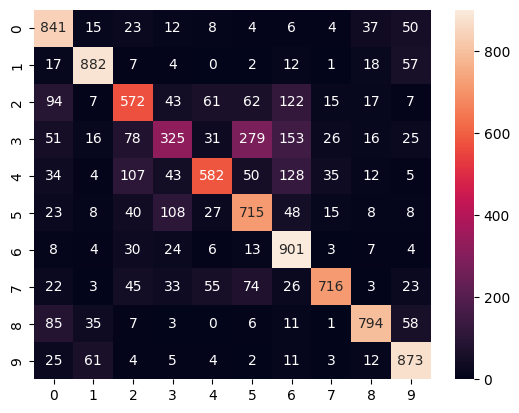

In [162]:
from seaborn import heatmap
heatmap(confusion_matrix(test_labels_int, pred_labels_def_flip), annot=True, fmt='d');